In [3]:
from persim import plot_diagrams
from sklearn.linear_model import LogisticRegression
from pathlib import Path
import numpy as np

from teaspoon.ML.Base import ParameterBucket


def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return point_clouds, labels


def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [5]:
from pathlib import Path

R = 0.65
n_signals = 100
DATA = Path("./data")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


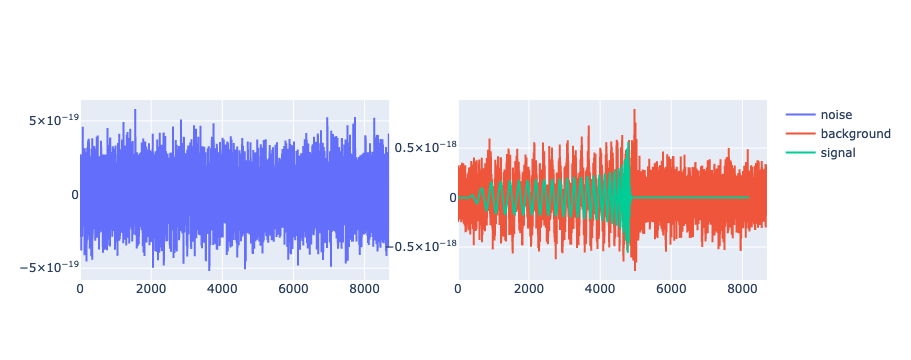

In [6]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()



import matplotlib.pyplot as plt

def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')



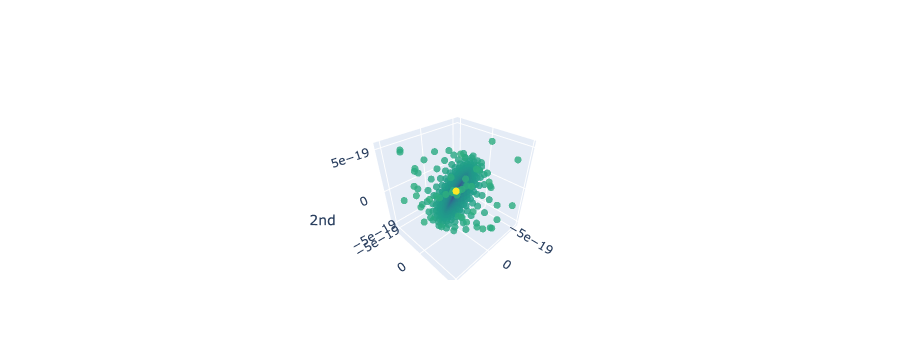

In [13]:
from gtda.time_series import SingleTakensEmbedding
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = embedder.fit_transform(gw_signals[0])

plot_point_cloud(y_gw_embedded)

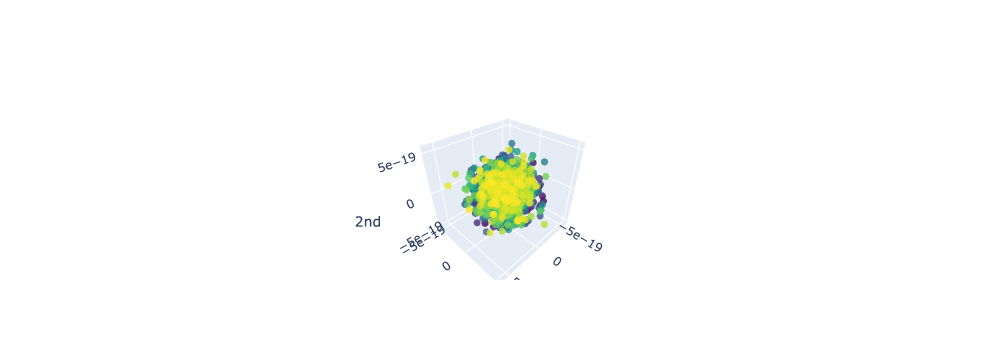

In [15]:
embedding_dimension = 20
embedding_time_delay = 10
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = embedder.fit_transform(noisy_signals[background_idx])

pca = PCA(n_components=3)
noise_data = pca.fit_transform(y_noise_embedded)

plot_point_cloud(noise_data)



In [17]:

from gtda.diagrams import PersistenceEntropy, Scaler, PersistenceLandscape, PersistenceImage
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding

embedding_dimension = 200
embedding_time_delay = 10
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)
#
persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=-1)
#
scaling = Scaler()

# ------------------ Featurization (uncommnet as needed) ------------------------------


# landscape = PersistenceLandscape(n_bins=50, n_jobs=-1)

# PersistenceImage = PersistenceImage(sigma=5, n_bins = 50 , n_jobs=-1)

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         # ("PersistenceImage", PersistenceImage)
         # ("landscape", landscape)
         ("entropy", entropy)
         ]

# --------------------------------------------------------------------------------------
topological_transfomer = Pipeline(steps)

features = topological_transfomer.fit_transform(noisy_signals)

/Users/emanuelayalalopez/anaconda3/lib/python3.10/site-packages/sklearn/utils/metaestimators.py:201: FutureWarning:

if_delegate_has_method was deprecated in version 1.1 and will be removed in version 1.3. Use if_available instead.



In [19]:
# merged_features = np.reshape(features, (features.shape[0], -1))
# print(features)

# print(merged_features.shape)

In [20]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

classifiers = {
    'SVC': SVC(probability=True, kernel='poly', random_state=42),
    'Logistic Reg': LogisticRegression(max_iter=1000, random_state=42),
    'MLP': MLPClassifier(solver='adam', learning_rate='adaptive', max_iter=1000, learning_rate_init=0.5, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=5, random_state=42, criterion='log_loss')
}

results = {}
roc_auc_scores = {}

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=42, shuffle=True)

# Define the number of folds (k)
k = 10

# Create a RepeatedStratifiedKFold object
kf = RepeatedStratifiedKFold(n_splits=k, n_repeats=4)

# Iterate over the classifiers
for classifier_name, classifier in classifiers.items():
    print("Classifier:", classifier_name)
    fold_num = 1
    scores = []
    roc_auc_scores_list = []

    # Iterate over the folds
    for train_index, test_index in kf.split(X_train, y_train):
        # Get the training and testing data for this fold
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Train the classifier on this fold
        classifier.fit(X_train_fold, y_train_fold)

        # Print the scores for this fold (Uncomment as needed)
        # print_scores(classifier, fold_num)
        # print()

        fold_num += 1
        # Store the scores in the results dictionary
        y_valid_pred = classifier.predict_proba(X_valid)[:, 1]
        scores.append(accuracy_score(y_test_fold, classifier.predict(X_test_fold)))
        roc_auc_scores_list.append(roc_auc_score(y_valid, y_valid_pred))

    results[classifier_name] = scores
    roc_auc_scores[classifier_name] = roc_auc_scores_list


Classifier: SVC
Classifier: Logistic Reg
Classifier: MLP
Classifier: Random Forest


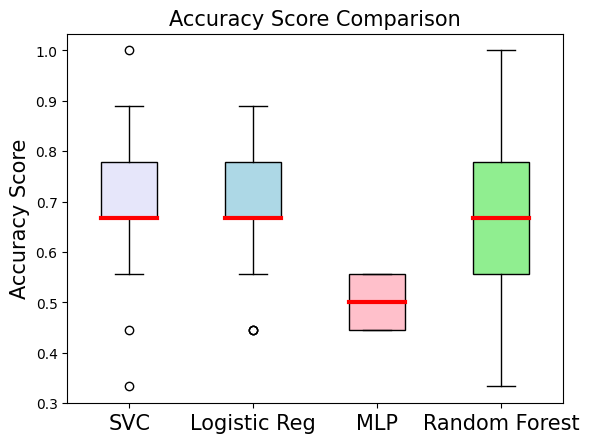

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Boxplot data for accuracy scores
boxplot_data = [results[classifier_name] for classifier_name in classifiers.keys()]

# Define the colors for each box
colors = ['lavender', 'lightblue', 'pink', 'lightgreen']

# Create the accuracy score boxplot with specified colors
boxplot = ax.boxplot(boxplot_data, patch_artist=True)

# Set the facecolor for each accuracy score box
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Set the linewidth for the median line (red line) of accuracy scores
for median in boxplot['medians']:
    median.set_color('red')
    median.set_linewidth(3)

ax.set_xticklabels(classifiers.keys(), fontsize=15)
ax.set_ylabel('Accuracy Score', fontsize=15)
plt.title('Accuracy Score Comparison', fontsize=15)
plt.show()


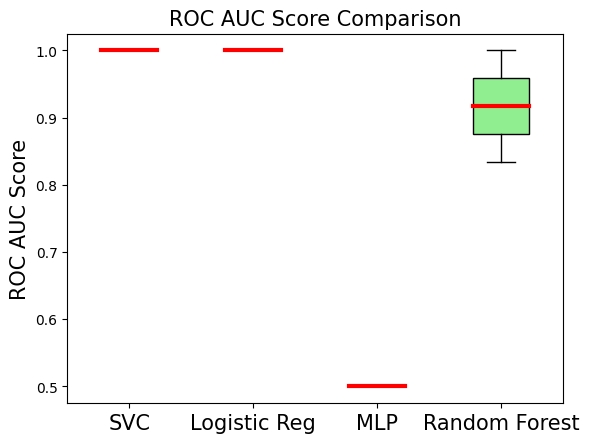

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Boxplot data for ROC AUC scores
roc_auc_boxplot_data = [roc_auc_scores[classifier_name] for classifier_name in classifiers.keys()]

# Create the ROC AUC score boxplot with specified colors
boxplot_roc_auc = ax.boxplot(roc_auc_boxplot_data, patch_artist=True)

# Set the facecolor for each ROC AUC score box
for patch, color in zip(boxplot_roc_auc['boxes'], colors):
    patch.set_facecolor(color)

# Set the linewidth for the median line (red line) of ROC AUC scores
for median in boxplot_roc_auc['medians']:
    median.set_color('red')
    median.set_linewidth(3)

ax.set_xticklabels(classifiers.keys(), fontsize=15)
ax.set_ylabel('ROC AUC Score', fontsize=15)
plt.title('ROC AUC Score Comparison', fontsize=15)
plt.show()


/Users/emanuelayalalopez/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

/Users/emanuelayalalopez/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.

/Users/emanuelayalalopez/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of 

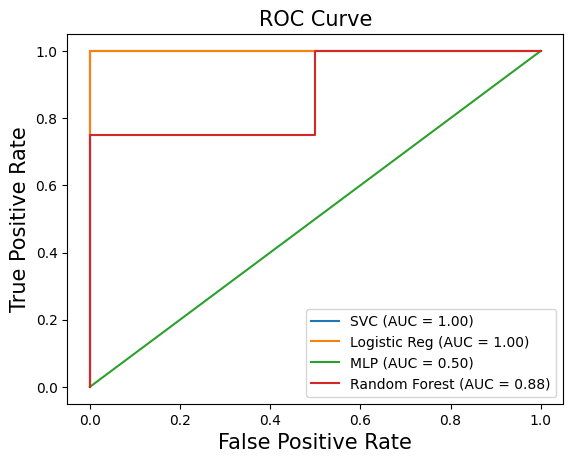

In [23]:
# Plot the ROC curves for each classifier
fig, ax = plt.subplots()

for classifier_name in classifiers.keys():
    plot_roc_curve(classifiers[classifier_name], X_valid, y_valid, ax=ax, name=classifier_name)

# Set the x-axis and y-axis labels and title
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
plt.title('ROC Curve', fontsize=15)

# Show the legend
plt.legend()

# Show the plot
plt.show()
